# Federated Learning for Text Generation

In [2]:
# NOTE: If you are running a Jupyter notebook, and installing a locally built
# pip package, you may need to edit the following to point to the '.whl' file
# on your local filesystem.

# !pip install --quiet tensorflow_federated
# !pip install --quiet tf-nightly

# NOTE: Jupyter requires a patch to asyncio.
# !pip install --upgrade nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [3]:
from __future__ import absolute_import, division, print_function

import collections
import functools
import os
import six
import time
import glob
from datetime import datetime
import pickle

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

# Test the TFF is working:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
%load_ext tensorboard

# 1. Pre-train a centralized model on Trajnet dataset

http://trajnet.stanford.edu/


## 1.1 Load Benchmarking Data

In [6]:
path = 'benchmarking_data/Train/train/stanford/*.txt' 

samples_bm = {}
last_sample_bm_keys = {}

for filename in glob.iglob(path):
    for line in open(filename):
        data = line.strip('\n').split(' ')
        rid = data[1]
        x1 = float(data[2])/20.
        x2 = float(data[3])/20. - 1.
        if rid in samples_bm.keys():
            last_key = last_sample_bm_keys[rid]
            if(last_key not in samples_bm[rid]):
                samples_bm[rid][last_key] = []
            samples_bm[rid][last_key].append((x1, x2))
            if len(samples_bm[rid][last_key]) == 20:
                last_sample_bm_keys[rid]+=1
        else:
            samples_bm.update({rid: {}})
            samples_bm[rid].update({0: [(x1, x2)]})
            last_sample_bm_keys.update({rid: 0})

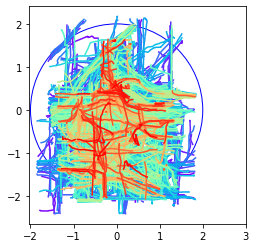

In [7]:
colors = cm.rainbow(np.linspace(0, 1, len(samples_bm.keys())))
cnt = 0


plt.figure()
for v in samples_bm.values():
    for traj in v.values():
        if (len(traj) > 0):
            x, y = zip(*traj)
        plt.plot(x, y, color=colors[cnt])
    cnt += 1
    
ax = plt.gca()
circle2 = plt.Circle((0, 0), 2, color='b', fill=False)
ax.add_artist(circle2)
plt.axis('square')
plt.show( )

In [8]:
# Count samples in dataset
count_traj = sum(len(v) for v in samples_bm.values())

print(count_traj)

8985


In [9]:
# Check the length of sequences
for k,v in samples_bm.items():
    for kk, vv in v.items():
             if len(vv) != 20:
                print(len(v),len(vv))

## 1.2 Create Labels

In [10]:
TRAIN_RATIO = 0.2
VAL_RATIO = 1 - TRAIN_RATIO
PAST_HISTORY = 12
FUTURE_TARGET = 8
TIME_STEP = 0.1

BATCH_SIZE = 16
BUFFER_SIZE = 100

In [11]:
def tuple_list_data(dataset, start_index, end_index, history_size):
    data = []
    labels = []
    list_dataset = list(dataset.values())
    for i in range(start_index, end_index):
        data.append(np.asarray(list_dataset)[i][:history_size])
        labels.append(np.asarray(list_dataset)[i][history_size:])
        
    data = np.asarray(data).reshape(end_index-start_index, history_size, 2)
    labels = np.asarray(labels).reshape(end_index-start_index, len(list_dataset[0]) - history_size , 2)
    
    return data, labels

## 1.3 Create tf Dataset

In [12]:
x_train = np.zeros((1,PAST_HISTORY,2))
y_train = np.zeros((1,FUTURE_TARGET,2))
x_val = np.zeros((1,PAST_HISTORY,2))
y_val = np.zeros((1,FUTURE_TARGET,2))

for v in samples_bm.values():
    tot_samples = len(v)
    train_split = round(TRAIN_RATIO * tot_samples)
    x_train_tmp, y_train_tmp = tuple_list_data(v, 0, train_split, PAST_HISTORY)
    x_val_tmp, y_val_tmp = tuple_list_data(v, train_split, tot_samples, PAST_HISTORY)
    x_train = np.concatenate([x_train, x_train_tmp], axis=0)
    y_train = np.concatenate([y_train, y_train_tmp], axis=0)
    x_val = np.concatenate([x_val, x_val_tmp], axis=0)
    y_val = np.concatenate([y_val, y_val_tmp], axis=0)
    

In [13]:
x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train, 49, dtype='float32', padding='post', value=-10)
y_train_padded = tf.keras.preprocessing.sequence.pad_sequences(y_train, 49, dtype='float32', padding='post', value=-10)
x_val_padded = tf.keras.preprocessing.sequence.pad_sequences(x_val, 49, dtype='float32', padding='post', value=-10)
y_val_padded = tf.keras.preprocessing.sequence.pad_sequences(y_val, 49, dtype='float32', padding='post', value=-10)

In [14]:
train_set = tf.data.Dataset.from_tensor_slices((x_train_padded, y_train_padded))
train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_set = tf.data.Dataset.from_tensor_slices((x_val_padded, y_val_padded))
val_set = val_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

## 1.4 Custom Loss Function (todo)

In [15]:
def r3_bivariate_gaussian_loss(true, pred):
    """
    Rank 3 bivariate gaussian loss function
    Returns results of eq # 24 of http://arxiv.org/abs/1308.0850
    :param true: truth values with at least [mu1, mu2, sigma1, sigma2, rho]
    :param pred: values predicted from a model with the same shape requirements as truth values
    :return: the log of the summed max likelihood
    """
    x_coord = true[:, :, 0]
    y_coord = true[:, :, 1]
    mu_x = pred[:, :, 0]
    mu_y = pred[:, :, 1]

    # exponentiate the sigmas and also make correlative rho between -1 and 1.
    # eq. # 21 and 22 of http://arxiv.org/abs/1308.0850
    # analogous to https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/model.py#L326
    sigma_x = K.exp(K.abs(pred[:, :, 2]))
    sigma_y = K.exp(K.abs(pred[:, :, 3]))
    rho = K.tanh(pred[:, :, 4]) * 0.1  # avoid drifting to -1 or 1 to prevent NaN, you will have to tweak this multiplier value to suit the shape of your data

    norm1 = K.log(1 + K.abs(x_coord - mu_x))
    norm2 = K.log(1 + K.abs(y_coord - mu_y))

    variance_x = K.softplus(K.square(sigma_x))
    variance_y = K.softplus(K.square(sigma_y))
    s1s2 = K.softplus(sigma_x * sigma_y)  # very large if sigma_x and/or sigma_y are very large

    # eq 25 of http://arxiv.org/abs/1308.0850
    z = ((K.square(norm1) / variance_x) +
         (K.square(norm2) / variance_y) -
         (2 * rho * norm1 * norm2 / s1s2))  # z → -∞ if rho * norm1 * norm2 → ∞ and/or s1s2 → 0
    neg_rho = 1 - K.square(rho)  # → 0 if rho → {1, -1}
    numerator = K.exp(-z / (2 * neg_rho))  # → ∞ if z → -∞ and/or neg_rho → 0
    denominator = (2 * np.pi * s1s2 * K.sqrt(neg_rho)) + epsilon()  # → 0 if s1s2 → 0 and/or neg_rho → 0
    pdf = numerator / denominator  # → ∞ if denominator → 0 and/or if numerator → ∞
    return K.log(K.sum(-K.log(pdf + epsilon())))  # → -∞ if pdf → ∞

## 1.5 Pre-train a Non Federated LSTM

In [78]:
print(train_set)

<RepeatDataset shapes: ((None, 49, 2), (None, 49, 2)), types: (tf.float32, tf.float32)>


In [17]:
print ('Single window of past history : {}'.format(x_train_padded[0].shape))
print ('\n Target trajectory to predict : {}'.format(y_train_padded[0].shape))

Single window of past history : (49, 2)

 Target trajectory to predict : (49, 2)


In [18]:
tf.keras.backend.set_floatx('float32')

In [79]:
EMBEDDING_SIZE = 32
DROP_RATE = 0.3
NUM_OUTPUTS = 2

def create_model():
    return tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-10.,input_shape=x_train_padded.shape[-2:]),
    tf.keras.layers.LSTM(EMBEDDING_SIZE,
                         return_sequences=True,
                         input_shape=x_train_padded.shape[-2:]),
    tf.keras.layers.Dense(NUM_OUTPUTS)
    ])
#     tf.keras.layers.Dropout(DROP_RATE),



In [20]:
model = create_model()

for x, y in val_set.take(1):
    print(model.predict(x).shape)

(16, 49, 2)


In [80]:
EVALUATION_INTERVAL = 50
EPOCHS = 200  
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

simple_lstm_model = create_model()
simple_lstm_model.compile(optimizer='adam',
        loss='mean_absolute_error')
centralized = simple_lstm_model.fit(train_set, epochs=EPOCHS,
              steps_per_epoch=EVALUATION_INTERVAL,
              validation_data=val_set, validation_steps=50,
              callbacks=[tensorboard_callback])

# Note: with the regularization loss, it's normal that the validation loss is smaller than the training loss!

Train for 50 steps, validate for 50 steps


KeyboardInterrupt: 

In [75]:

print(vars(history))
print(centralize.history['loss'])
print(centralize.history['val_loss'])

{'validation_data': None, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7febc9eef5f8>, '_chief_worker_only': None, 'params': {'batch_size': None, 'epochs': 2, 'steps': 50, 'samples': 50, 'verbose': 0, 'do_validation': True, 'metrics': ['loss', 'val_loss']}, 'epoch': [0, 1], 'history': {'loss': [0.8846946716308594, 0.7352992415428161], 'val_loss': [0.8187583839893341, 0.6199520266056061]}}
[0.8846946716308594, 0.7352992415428161]


In [22]:
print(train_set)

<RepeatDataset shapes: ((None, 49, 2), (None, 49, 2)), types: (tf.float32, tf.float32)>


In [23]:
from tensorflow.keras.models import load_model

simple_lstm_model.save('pretrained_lstm.h5')  # creates a HDF5 file 'my_model.h5'
#del simple_lstm_model  # deletes the existing model

In [ ]:
%tensorboard --logdir logs --port 6006

In [25]:
from mpl_toolkits.mplot3d import Axes3D

def create_time_steps(length):
    return list(range(-length, 0))

In [26]:
def multi_step_plot(history, true_future, prediction):

    history=np.array(history[history!=-10]).reshape([-1, 2])
    prediction=np.array(prediction[true_future!=-10]).reshape([-1,2])
    true_future=np.array(true_future[true_future!=-10]).reshape([-1, 2])
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.set_xlim([-10,10])
    ax.set_ylim([-2,2])
    
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, history[:, 0], 'b', label='History_x')
    plt.plot(num_in, history[:, 1], 'b', label='History_y')
    plt.plot(np.arange(num_out), true_future, 'bo-',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), prediction, 'ro',
                 label='Predicted Future')
        plt.legend(loc='upper left')
        plt.show()

In [27]:
def multi_step_plot_3D(history, true_future, prediction):
    history=np.array(history[history!=-10]).reshape([-1, 2])
    prediction=np.array(prediction[true_future!=-10]).reshape([-1,2])
    true_future=np.array(true_future[true_future!=-10]).reshape([-1, 2])
    
    fig = plt.figure(figsize=(12, 6))
    ax = Axes3D(fig)
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-10,10])
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    ax.plot3D(np.array(history[:, 0]), np.array(history[:, 1]), num_in, 'bo-', label='History')
    ax.plot3D(np.array(true_future[:,0]), np.array(true_future[:,1]), np.arange(num_out), 'bo',
           label='True Future')
    if prediction.any():
        ax.plot3D(np.array(prediction[:,0]), np.array(prediction[:,1]), np.arange(num_out), 'ro',
                 label='Predicted Future')
        plt.legend(loc='upper left')
        plt.show()

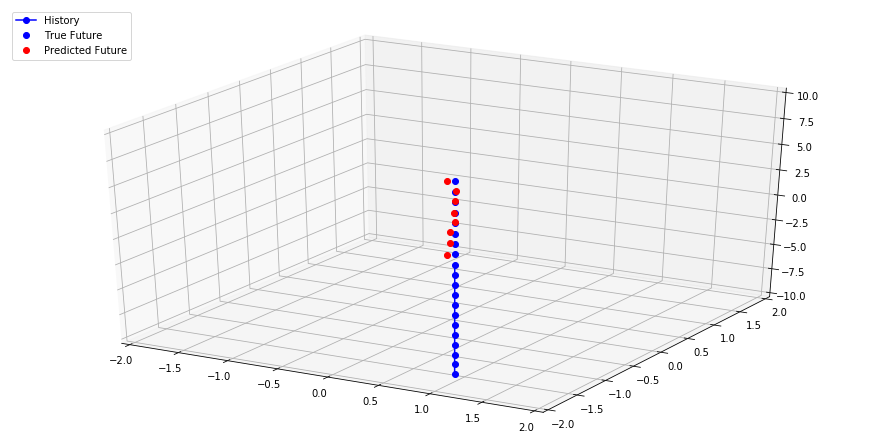

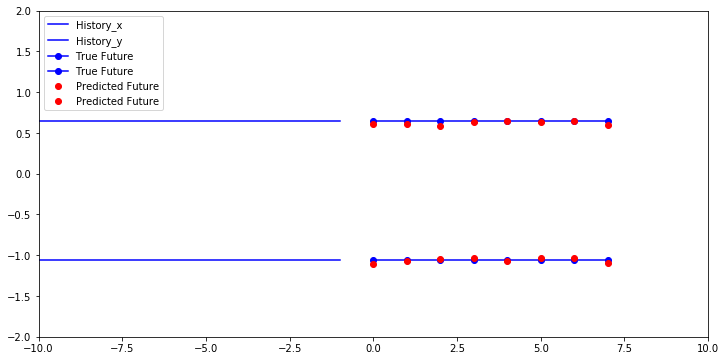

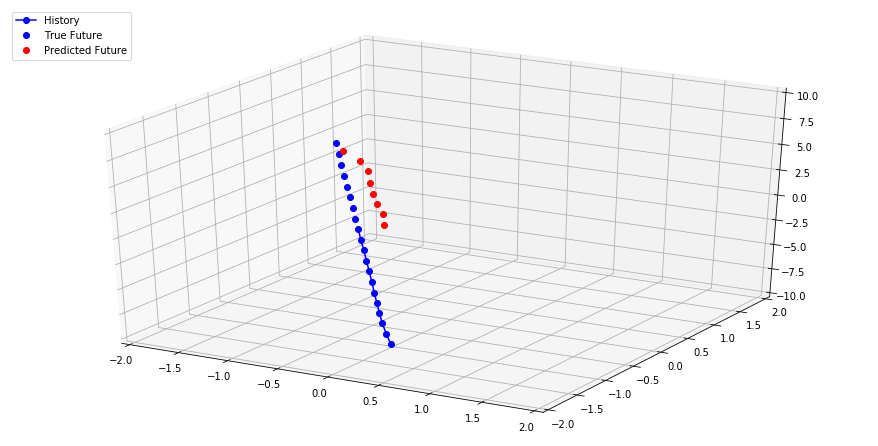

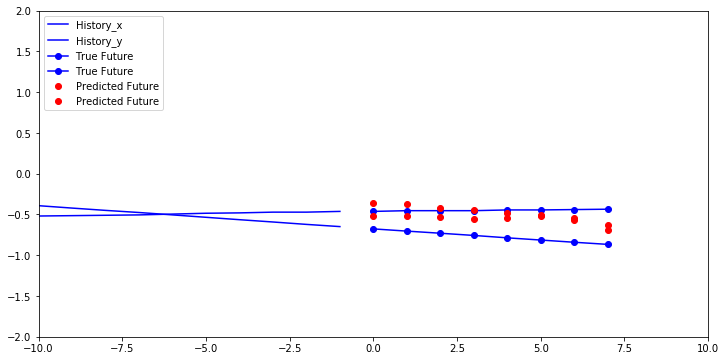

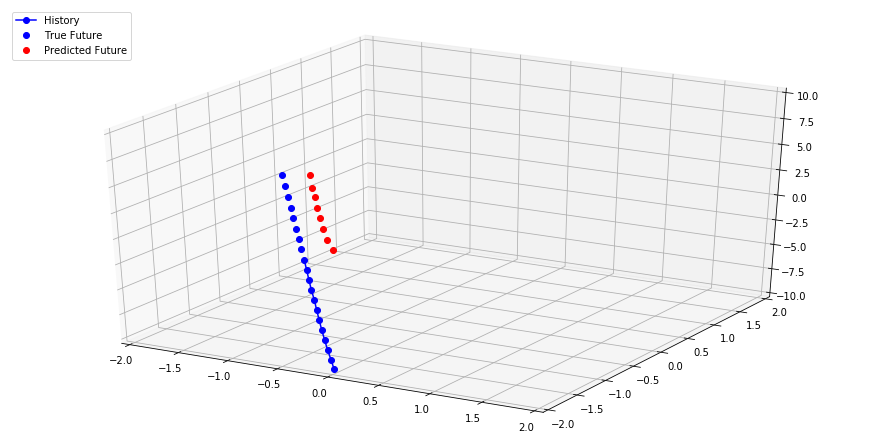

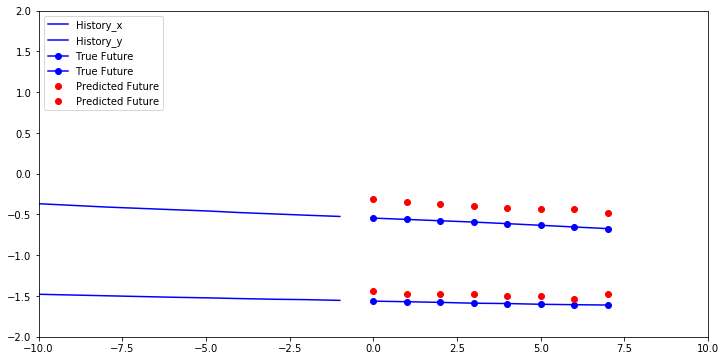

In [28]:
# Stanford validation set
for x, y in val_set.take(3):
    multi_step_plot_3D(history=x[0], true_future=y[0], prediction=simple_lstm_model.predict(x)[0])
    multi_step_plot(history=x[0], true_future=y[0], prediction=simple_lstm_model.predict(x)[0])

# 2. Client-partioned Federated Learning from Trajectory Data


## 2.1 Load Distributed Data

In [29]:
path = '../data/short_data/avoidance_20200127_1615**.dat'#'../data/[!G_][!flocking]**.dat' #foraging_20191211_213418.dat' #foraging**.dat'

samples = {}
last_sample_keys = {}

for filename in glob.iglob(path):
    print(filename)
    for line in open(filename):
        data = line.split(',')
        if len(data) == 7:
            rid = data[0]
            x1 = float(data[3])
            x2 = float(data[4])
            if rid in samples.keys():
                last_key = last_sample_keys[rid]
                if(last_key not in samples[rid]):
                    samples[rid][last_key] = []
                samples[rid][last_key].append((x1, x2))
                if len(samples[rid][last_key]) == 99:
                    del samples[rid][last_key][98]
                    last_sample_keys[rid]+=1
            else:
                samples.update({rid: {}})
                samples[rid].update({0: [(x1, x2)]})
                last_sample_keys.update({rid: 0})
        else:
            last_key = last_sample_keys[rid] 
            if(last_key in samples[rid] and len(samples[rid][last_key]) != 0):
                last_sample_keys[rid]+=1

../data/short_data/avoidance_20200127_161547.dat
../data/short_data/avoidance_20200127_161516.dat
../data/short_data/avoidance_20200127_161523.dat
../data/short_data/avoidance_20200127_161518.dat
../data/short_data/avoidance_20200127_161540.dat
../data/short_data/avoidance_20200127_161500.dat
../data/short_data/avoidance_20200127_161542.dat


## 2.3 Visualize Data

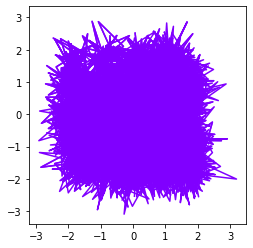

In [30]:
TIME_STEP = 0.1

colors = cm.rainbow(np.linspace(0, 1, len(samples.keys())))
cnt = 0

plt.figure()
for v in samples.values():
    for traj in v.values():
        if (len(traj) > 0):
            x, y = zip(*traj)
        plt.plot(x, y, color=colors[cnt])
    cnt += 1
    break
    
ax = plt.gca()
circle2 = plt.Circle((0, 0), 2, color='b', fill=False)
ax.add_artist(circle2)
plt.axis('square')
plt.show( )

In [31]:
count_traj = sum(len(v) for v in samples.values())

print(count_traj)

14546


In [32]:
for k,v in samples.items():
    for kk, vv in v.items():
        if len(vv) != 98:
            print(len(v),len(vv))

## 2.4 Create Labels

In [33]:
def tuple_list_data(dataset, start_index, end_index, history_size):
    data = []
    labels = []
    list_dataset = list(dataset.values())
    for i in range(start_index, end_index):
        data.append(np.asarray(list_dataset)[i][:history_size])
        labels.append(np.asarray(list_dataset)[i][history_size:])
        
    data = np.asarray(data).reshape(end_index-start_index, history_size, 2)
    labels = np.asarray(labels).reshape(end_index-start_index, len(list_dataset[0]) - history_size , 2)
    
    return data, labels

## 2.5 Create tff Dataset and tf Dataset Per Client

In [34]:
TRAIN_RATIO = 0.2
VAL_RATIO = 1 - TRAIN_RATIO
PAST_HISTORY = 49
TIME_STEP = 0.1

BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [35]:
count = 1
dict_train_dataset = {}
dict_val_dataset = {}
for v in samples.values():
    tot_samples = round(len(v)/5)
    train_split = round(TRAIN_RATIO * tot_samples)
    x_train, y_train = tuple_list_data(v, 0, train_split, PAST_HISTORY)
    x_val, y_val = tuple_list_data(v, train_split, tot_samples, PAST_HISTORY)
    dict_train_dataset.update({count: (x_train, y_train)})
    dict_val_dataset.update({count: (x_val, y_val)})
    count+=1
    
#     train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#     train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#     val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#     val_set = val_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [36]:
print(x_train.shape, y_train.shape)

(18, 49, 2) (18, 49, 2)


In [37]:
tff_train_set = tff.simulation.FromTensorSlicesClientData(dict_train_dataset)
tff_val_set = tff.simulation.FromTensorSlicesClientData(dict_val_dataset)

In [38]:
filehandler = open('tff_train_set_'+ datetime.now().strftime("%Y%m%d-%H%M%S"), 'wb') 
pickle.dump(tff_train_set, filehandler)
filehandler = open('tff_val_set_'+ datetime.now().strftime("%Y%m%d-%H%M%S"), 'wb') 
pickle.dump(tff_val_set, filehandler)

In [39]:
print(tff_train_set.client_ids)
print(tff_train_set._output_shapes)
# print(vars(tff_train_set))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
(TensorShape([49, 2]), TensorShape([49, 2]))


In [40]:
def preprocess(dataset):
    return (
      dataset.cache()
      #form minibatches
      .batch(BATCH_SIZE))

In [41]:
example_dataset = train_set

In [42]:
print(example_dataset)
print(tf.data.experimental.get_structure(example_dataset))

<RepeatDataset shapes: ((None, 49, 2), (None, 49, 2)), types: (tf.float32, tf.float32)>
(TensorSpec(shape=(None, 49, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 49, 2), dtype=tf.float32, name=None))


In [43]:
def data(client, source=tff_train_set):
    return preprocess(source.create_tf_dataset_for_client(client)).take(2)

clients = [1, 2, 3]

train_datasets = [data(client) for client in clients]

# We concatenate the test datasets for evaluation with Keras.
test_dataset = functools.reduce(
    lambda d1, d2: d1.concatenate(d2),
    [data(client, tff_val_set) for client in clients])

# NOTE: If the statement below fails, it means that you are
# using an older version of TFF without the high-performance
# executor stack. Call `tff.framework.set_default_executor()`
tff.framework.set_default_executor(tff.framework.create_local_executor())

## Serialize the keras model into a tff model

In [44]:
BATCH_SIZE=16
SEQ_LENGTH=49

In [45]:
#del simple_lstm_model
simple_lstm_model = tf.keras.models.load_model('pretrained_lstm.h5', compile=False)

In [46]:
def tff_model():
    x = tf.constant(np.random.uniform(-2., 2., size=[BATCH_SIZE, SEQ_LENGTH, 2]))
    dummy_batch = collections.OrderedDict([('x', x), ('y', x)]) 
    keras_model_clone =tf.keras.models.clone_model(simple_lstm_model)
    keras_model_clone.compile(optimizer='adam', loss='mean_absolute_error')
    return tff.learning.from_compiled_keras_model(keras_model_clone,dummy_batch)

In [47]:
# This command builds all the TensorFlow graphs and serializes them: 
fed_avg = tff.learning.build_federated_averaging_process(model_fn=tff_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [48]:
state = fed_avg.initialize()

In [49]:
state = tff.learning.state_with_new_model_weights(
    state,
    trainable_weights=[v.numpy() for v in simple_lstm_model.trainable_weights],
    non_trainable_weights=[
        v.numpy() for v in simple_lstm_model.non_trainable_weights
    ])

In [50]:
NUM_ROUNDS=3
simple_lstm_model.compile(optimizer='adam', loss='mean_absolute_error')

def keras_evaluate(state, round_num):
    tff.learning.assign_weights_to_keras_model(simple_lstm_model, state.model)
    print('Evaluating before training round', round_num)
    simple_lstm_model.evaluate(example_dataset, steps=2)

for round_num in range(NUM_ROUNDS):
    keras_evaluate(state, round_num)
    # N.B. The TFF runtime is currently fairly slow,
    # expect this to get significantly faster in future releases.
    state, metrics = fed_avg.next(state, train_datasets)
    print('Training metrics: ', metrics)

keras_evaluate(state, NUM_ROUNDS + 1)

Evaluating before training round 0
2/2 [==============================] - 0s 174ms/step - loss: 0.0267
Training metrics:  <loss=8.024518013000488>
Evaluating before training round 1
2/2 [==============================] - 0s 6ms/step - loss: 0.0224
Training metrics:  <loss=7.997725963592529>
Evaluating before training round 2
2/2 [==============================] - 0s 7ms/step - loss: 0.0292
Training metrics:  <loss=7.970599174499512>
Evaluating before training round 4
2/2 [==============================] - 0s 7ms/step - loss: 0.0316


# 3. Continuous Data Collection and Multi-Hop Network

## 3.1 Load Temporal Data

In [51]:
path = '../data/avoidance_20200131**.dat'#'../data/[!G_][!flocking]**.dat' #foraging_20191211_213418.dat' #foraging**.dat'

samples = {} #samples{ <exp_id> : {<rid>: { <traj_id> : { 'traj' : [], 'end' : <time_collected> }}}

for filename in glob.iglob(path):
    print(filename)
    exp_id = filename[-10:-4]
    last_sample_keys = {}
    samples.update({exp_id : {}})
    for line in open(filename):
        data = line.split(',')
        if len(data) == 7:
            rid = int(data[0])
            t = int(data[2])
            x1 = float(data[3])
            x2 = float(data[4])
            if rid in samples[exp_id].keys():
                last_key = last_sample_keys[rid]
                if(last_key not in samples[exp_id][rid]):
                    samples[exp_id][rid][last_key] = {'traj': [], 'end' : 0}
                samples[exp_id][rid][last_key]['traj'].append((x1, x2))
                samples[exp_id][rid][last_key]['end'] = t
                if len(samples[exp_id][rid][last_key]['traj']) == 99:
                    del samples[exp_id][rid][last_key]['traj'][98]
                    samples[exp_id][rid][last_key]['end'] = t
                    last_sample_keys[rid]+=1
            else:
                samples[exp_id].update({rid: {}})
                samples[exp_id][rid].update({0: {'traj': [(x1, x2)], 'end': 0}})
                last_sample_keys.update({rid: 0})
        else:
            last_key = last_sample_keys[rid] 
            if(last_key in samples[exp_id][rid] and len(samples[exp_id][rid][last_key]) != 0):
                last_sample_keys[rid]+=1

../data/avoidance_20200131_205449.dat
../data/avoidance_20200131_204700.dat
../data/avoidance_20200131_204454.dat


In [52]:
print(samples.keys())

dict_keys(['205449', '204700', '204454'])


In [53]:
print(len(samples['205449'][1].keys()))
print(len(samples['205449'][3].keys()))
print(len(samples['204700'][1].keys()))#[10]['traj'])
print(len(samples['204454'][1].keys()))
print(samples['205449'][1][10]['end'])

7795
7360
5828
3373
123


In [54]:
print(samples['205449'].keys())

dict_keys([1, 10, 11, 12, 13, 14, 15, 16, 17, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 5, 6, 7, 8, 9, 18])


In [55]:
for k,v in samples['205449'].items():
    for kk, vv in v.items():
        if len(vv['traj']) != 98:
            print(len(v),len(vv['traj']))

## 3.2 Load Graph Data

In [56]:
path = '../data/G_avoidance_20200131**.dat'

neighbors = {}  #neigbors{ <exp_id> : {<rid>: { <t> : [<neighbors>]}}

for filename in glob.iglob(path):
    print(filename)    
    exp_id = filename[-10:-4]
    neighbors.update({exp_id : {}})
    for line in open(filename):
        data = line.split(',')
        rid = int(data[0])
        t = int(data[1])
        nid = int(data[2])
        if(t != 0):
            if(rid not in neighbors[exp_id].keys()):
                neighbors[exp_id].update({rid: {}})
            if(t not in neighbors[exp_id][rid].keys()):
                neighbors[exp_id][rid].update({t:[]})
            neighbors[exp_id][rid][t].append(nid)

../data/G_avoidance_20200131_204454.dat
../data/G_avoidance_20200131_204700.dat
../data/G_avoidance_20200131_205449.dat


## 3.3 Simulation

In [57]:
class VSElem():
    def __init__(self, data, t, i):
        self.data = data
        self.timestamp = t
        self.rid = i

class VirtualStigmery():
    def __init__(self, vid):
        self.id = vid
        self.dict = {}
        
#     def put():
    
    
#     def __call__():

# 1) vstig : key = round_num, data = < num_writes, weights_average > and store last 
#    round participated in (but conflicts problematic)
# 2) vstig : key = round_num, data = < rid_list, weights > and last round participated in (but increased load)
# 3) vstig : id = round_num, key = rid, data = < weights > and last round participated in (but delay in getting
# the newest round? or possible to start a wrong round)
# Furthermore, to avoid conflicts, do we stop at exactly a certain number of participants for the weight average?
# one vstig (1-2) or one per round (3) ? or CRDT after all ?
        

### 3.3.1 Rounds by global clock and data mininum

In [58]:
EXP_DURATION = 100000 # + authorized time to perform extra training?
DATASET_PARTITION = 30
BATCH_SIZE = DATASET_PARTITION
LOCAL_EPOCHS = 1 # 10 100
TRAIN_FRAC = 0.8
NUM_ROUNDS = 40
ROUND_DURATION = int(EXP_DURATION / NUM_ROUNDS)

TRAIN_RATIO = 0.8
VAL_RATIO = 1 - TRAIN_RATIO
PAST_HISTORY = 49
FUTURE_TARGET = 49

In [59]:
def convert_data(dataset, start_index, end_index, history_size):
    data = []
    labels = []
    list_dataset = list(dataset)
    for i in range(start_index, end_index):
        data.append(np.asarray(list_dataset)[i][:history_size])
        labels.append(np.asarray(list_dataset)[i][history_size:])
        
    data = np.asarray(data).reshape(end_index-start_index, history_size, 2)
    labels = np.asarray(labels).reshape(end_index-start_index, len(list_dataset[0]) - history_size , 2)
    
    return data, labels

In [66]:
def average_weights(weights):
    avg = np.zeros_like(trainable_weights[1][1])
    count = 0
    for k,v in weights.items():
        if(len(v) != 0):
            avg = np.add(avg, v)
            count += 1
    if(count != 0):
        avg = avg/count
    avg = np.squeeze(avg)
    return avg   

In [61]:
print(samples.keys())

dict_keys(['205449', '204700', '204454'])


In [67]:
# For each experiment
for exp in samples.keys():
    # Per experiment settings 
    num_robots = len(samples[exp].keys())
    # Un-synch clocks by random integer
    time_offsets = np.random.randint(0, 10, size=(num_robots,))
    # Load the pre-trained LSTM
    simple_lstm = tf.keras.models.load_model('pretrained_lstm.h5', compile=False)
    # Set global clock to 0
    global_clock = 0
    round_num = 1
    # Initialize weights
    trainable_weights = {}
    w  = [v.numpy() for v in simple_lstm.trainable_weights]
    w_list = [[w] for i in range(num_robots)]
    trainable_weights[round_num] = {k : v for (k, v) in zip(range(1, num_robots + 1), w_list)}
    leftover_samples_buffer = {}
    prev = np.zeros(num_robots, dtype=int)
    
    for t in range(0, EXP_DURATION, ROUND_DURATION):
        
        print("Round ", round_num)
        # One round for each robot: data collection, local training and global update
        for i in samples[exp].keys():
            batch = []
            # Batch DATASET_PARTITION samples 
            # Get time of end of needed data collection
            
            time_at_batch_collection = samples[exp][i][prev[i-1] + DATASET_PARTITION]['end']
            
#             time_at_batch_collection = samples[exp][i][(DATASET_PARTITION * round_num)- 1]['end']
            
            cond = True
            idx = (DATASET_PARTITION * round_num - 1)
            while(cond):
                idx+=1
                if(samples[exp][i][idx]['end'] > ROUND_DURATION * round_num):
                    cond = False
            print(i, ": ", time_at_batch_collection, " ", ROUND_DURATION * round_num)
            
            # Check that we have enough data collected to participate in the round
            if(time_at_batch_collection <= ROUND_DURATION * round_num):
                # Take extra data collected before end of round
                print("sample indices ", prev[i-1], idx)
                tmp = [samples[exp][i][j]['traj'] for j in range(prev[i-1], idx)]
                batch.append(tmp)
                # Take remaining data from previous round
                if(i in leftover_samples_buffer.keys() and len(leftover_samples_buffer[i]) > 0):
                    batch.append(leftover_samples_buffer[i])
                    leftover_samples_buffer[i] = []
            else:
                # Check that we have enough previous data
                if( i in leftover_samples_buffer.keys() and len(leftover_samples_buffer[i]) >= DATASET_PARTITION):
                    batch.append(leftover_samples_buffer[i])
                    leftover_samples_buffer[i] = []
                else:
                    if(i not in leftover_samples_buffer.keys()):
                        leftover_samples_buffer.update({i: []})
                    leftover_samples_buffer[i] = [samples[exp][i][j]['traj'] for j in range(prev[i-1], idx)]
                    prev[i-1] = idx
                    print('Robot not participating', i)
                    continue
                    
            prev[i-1] = idx
            # Get weights 
            current_weights = average_weights(trainable_weights[round_num])
            # Perform local training
            # Create datasets
            x_train = np.zeros((1,PAST_HISTORY,2))
            y_train = np.zeros((1,FUTURE_TARGET,2))
            x_val = np.zeros((1,PAST_HISTORY,2))
            y_val = np.zeros((1,FUTURE_TARGET,2))
            for v in batch:
                tot_samples = len(v)
                train_split = round(TRAIN_RATIO * tot_samples)
                print(len(v), train_split)
                x_train_tmp, y_train_tmp = convert_data(v, 0, train_split, PAST_HISTORY)
                x_val_tmp, y_val_tmp = convert_data(v, train_split, tot_samples, PAST_HISTORY)
                print(x_train_tmp.shape, y_train_tmp.shape)
                x_train = np.concatenate([x_train, x_train_tmp], axis=0)
                y_train = np.concatenate([y_train, y_train_tmp], axis=0)
                x_val = np.concatenate([x_val, x_val_tmp], axis=0)
                y_val = np.concatenate([y_val, y_val_tmp], axis=0)
            train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train))
            train_batch = train_batch.cache().batch(BATCH_SIZE).repeat()
            val_batch = tf.data.Dataset.from_tensor_slices((x_val, y_val))
            val_batch = val_batch.cache().batch(BATCH_SIZE).repeat()
            
            # Clone simple_lstm and initialize it with newest weights
            keras_model_clone =tf.keras.models.clone_model(simple_lstm)
            keras_model_clone.compile(optimizer='adam', loss='mean_absolute_error')
            keras_model_clone.set_weights(current_weights)
            keras_model_clone.fit(train_batch, epochs=LOCAL_EPOCHS,
              steps_per_epoch=EVALUATION_INTERVAL,
              validation_data=val_batch, validation_steps=50)
            # Write weights 
            if((round_num+1) not in trainable_weights.keys()):
                trainable_weights.update({(round_num+1): {}})
            trainable_weights[round_num+1].update({i: keras_model_clone.get_weights()})
        round_num+=1

Round  1
1 :  200   250
sample indices  0 27
27 22
(22, 49, 2) (22, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 71ms/step - loss: 4.7685 - val_loss: 0.3684
10 :  716   250
Robot not participating 10
11 :  200   250
sample indices  0 23
23 18
(18, 49, 2) (18, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 64ms/step - loss: 4.6349 - val_loss: 0.3009
12 :  247   250
sample indices  0 21
21 17
(17, 49, 2) (17, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 67ms/step - loss: 4.7327 - val_loss: 0.3973
13 :  301   250
Robot not participating 13
14 :  351   250
Robot not participating 14
15 :  305   250
Robot not participating 15
16 :  300   250
Robot not participating 16
17 :  200   250
sample indices  0 25
25 20
(20, 49, 2) (20, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 67ms/step - loss: 5.1791 - val_lo

50/50 [==============================] - 4s 78ms/step - loss: 0.1821 - val_loss: 0.1221
39 :  817   500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 67ms/step - loss: 0.1980 - val_loss: 0.0821
4 :  700   500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 8s 169ms/step - loss: 0.2080 - val_loss: 0.1244
40 :  988   500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 81ms/step - loss: 0.1827 - val_loss: 0.0855
5 :  695   500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 71ms/step - loss: 0.1703 - val_loss: 0.1551
6 :  565   500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 81ms/step - loss: 0.1919 - val_loss: 0.0800
7 :  517   500
20 16
(16, 49, 2) (

50/50 [==============================] - 4s 83ms/step - loss: 0.0817 - val_loss: 0.0805
22 :  1921   1500
Robot not participating 22
23 :  1884   1500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 77ms/step - loss: 0.1011 - val_loss: 0.1190
24 :  1739   1500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 79ms/step - loss: 0.0788 - val_loss: 0.0620
25 :  2234   1500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 84ms/step - loss: 0.1042 - val_loss: 0.0891
26 :  1669   1500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 87ms/step - loss: 0.1054 - val_loss: 0.1398
27 :  1590   1500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 65ms/step - loss: 0.0

50/50 [==============================] - 3s 66ms/step - loss: 0.0874 - val_loss: 0.2078
14 :  2138   2000
Robot not participating 14
15 :  2382   2000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0654 - val_loss: 0.0885
16 :  3125   2000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 8s 156ms/step - loss: 0.0892 - val_loss: 0.1102
17 :  2021   2000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 63ms/step - loss: 0.0643 - val_loss: 0.0961
19 :  2135   2000
Robot not participating 19
2 :  1907   2000
sample indices  180 210
30 24
(24, 49, 2) (24, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0740 - val_loss: 0.1171
20 :  1952   2000
sample indices  140 164
24 19
(19, 49, 2) (19, 49, 2)
20 16
(16, 49,

50/50 [==============================] - 4s 87ms/step - loss: 0.0912 - val_loss: 0.0998
15 :  2913   2750
Robot not participating 15
16 :  3896   2750
Robot not participating 16
17 :  2884   2750
Robot not participating 17
19 :  3444   2750
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 71ms/step - loss: 0.0859 - val_loss: 0.0877
2 :  3089   2750
Robot not participating 2
20 :  2708   2750
sample indices  214 239
25 20
(20, 49, 2) (20, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 65ms/step - loss: 0.0664 - val_loss: 0.0941
21 :  3529   2750
Robot not participating 21
22 :  2929   2750
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 82ms/step - loss: 0.0596 - val_loss: 0.0914
23 :  2920   2750
Robot not participating 23
24 :  2834   2750
Robot not participating 24
25 :  3440   2750
Robot not participating

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 81ms/step - loss: 0.0777 - val_loss: 0.1177
7 :  3104   3000
Robot not participating 7
8 :  3112   3000
Robot not participating 8
9 :  3232   3000
Robot not participating 9
18 :  3421   3000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 77ms/step - loss: 0.0787 - val_loss: 0.0932
Round  13
1 :  3323   3250
Robot not participating 1
10 :  3696   3250
Robot not participating 10
11 :  3507   3250
Robot not participating 11
12 :  3923   3250
Robot not participating 12
13 :  3592   3250
Robot not participating 13
14 :  3164   3250
sample indices  246 278
32 26
(26, 49, 2) (26, 49, 2)
17 14
(14, 49, 2) (14, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 77ms/step - loss: 0.0840 - val_loss: 0.0881
15 :  3462   3250
Robot not participating 15
16 :  4423   3250
Robot not participating 16
17 :  32

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 77ms/step - loss: 0.0579 - val_loss: 0.1088
38 :  3546   3500
Robot not participating 38
39 :  4617   3500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 10s 206ms/step - loss: 0.1014 - val_loss: 0.1336
4 :  4529   3500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 76ms/step - loss: 0.0812 - val_loss: 0.0693
40 :  3852   3500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 73ms/step - loss: 0.0841 - val_loss: 0.0747
5 :  3413   3500
sample indices  263 290
27 22
(22, 49, 2) (22, 49, 2)
12 10
(10, 49, 2) (10, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 88ms/step - loss: 0.1064 - val_loss: 0.1234
6 :  3669   3500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50

50/50 [==============================] - 3s 64ms/step - loss: 0.1017 - val_loss: 0.1044
24 :  4458   4500
sample indices  361 386
25 20
(20, 49, 2) (20, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 9s 177ms/step - loss: 0.0786 - val_loss: 0.1260
25 :  5277   4500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 65ms/step - loss: 0.0887 - val_loss: 0.1220
26 :  5660   4500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 62ms/step - loss: 0.0896 - val_loss: 0.1009
27 :  4686   4500
Robot not participating 27
28 :  4450   4500
sample indices  340 364
24 19
(19, 49, 2) (19, 49, 2)
18 14
(14, 49, 2) (14, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 63ms/step - loss: 0.1075 - val_loss: 0.1178
29 :  4832   4500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0690 - val_loss: 0.1321
22 :  5351   5000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0705 - val_loss: 0.1174
23 :  5261   5000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 62ms/step - loss: 0.1165 - val_loss: 0.1107
24 :  5021   5000
Robot not participating 24
25 :  5891   5000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 59ms/step - loss: 0.0867 - val_loss: 0.0647
26 :  6430   5000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0554 - val_loss: 0.0847
27 :  5294   5000
Robot not participating 27
28 :  4917   5000
sample indices  391 425
34 27
(27, 49, 2) (27, 49,

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0865 - val_loss: 0.1198
10 :  5841   5500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.1009 - val_loss: 0.1598
11 :  5647   5500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 59ms/step - loss: 0.0849 - val_loss: 0.1453
12 :  5839   5500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0913 - val_loss: 0.0955
13 :  5618   5500
Robot not participating 13
14 :  5886   5500
Robot not participating 14
15 :  5779   5500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0764 - val_loss: 0.1251
16 :  6856   5500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, 

50/50 [==============================] - 3s 61ms/step - loss: 0.0804 - val_loss: 0.1899
33 :  6818   6250
Robot not participating 33
34 :  6345   6250
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0613 - val_loss: 0.0648
35 :  6182   6250
sample indices  510 538
28 22
(22, 49, 2) (22, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 59ms/step - loss: 0.0620 - val_loss: 0.1093
36 :  7260   6250
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0452 - val_loss: 0.0256
37 :  6381   6250
Robot not participating 37
38 :  8011   6250
Robot not participating 38
39 :  6797   6250
Robot not participating 39
4 :  6899   6250
Robot not participating 4
40 :  7045   6250
Robot not participating 40
5 :  6390   6250
Robot not participating 5
6 :  6349   6250
Robot not participating 6


15 :  8057   7250
Robot not participating 15
16 :  8780   7250
Robot not participating 16
17 :  8856   7250
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 63ms/step - loss: 0.0783 - val_loss: 0.1115
19 :  8118   7250
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 64ms/step - loss: 0.0721 - val_loss: 0.0539
2 :  8674   7250
Robot not participating 2
20 :  7584   7250
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 62ms/step - loss: 0.0843 - val_loss: 0.0795
21 :  7799   7250
Robot not participating 21
22 :  7607   7250
Robot not participating 22
23 :  7613   7250
Robot not participating 23
24 :  7550   7250
Robot not participating 24
25 :  9247   7250
Robot not participating 25
26 :  9671   7250
Robot not participating 26
27 :  7524   7250
Robot not participating 27
28 :  7294   7250


Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0761 - val_loss: 0.1288
38 :  9613   8000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0807 - val_loss: 0.1136
39 :  8535   8000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.1050 - val_loss: 0.0869
4 :  9027   8000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 62ms/step - loss: 0.0717 - val_loss: 0.1280
40 :  8875   8000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 62ms/step - loss: 0.0676 - val_loss: 0.1117
5 :  7984   8000
sample indices  661 682
21 17
(17, 49, 2) (17, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61

50/50 [==============================] - 3s 60ms/step - loss: 0.0869 - val_loss: 0.1240
22 :  9331   9000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0722 - val_loss: 0.1264
23 :  9149   9000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0724 - val_loss: 0.0855
24 :  8910   9000
sample indices  727 758
31 25
(25, 49, 2) (25, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 59ms/step - loss: 0.0847 - val_loss: 0.1024
25 :  11206   9000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0768 - val_loss: 0.1228
26 :  11312   9000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0802 - val_loss: 0.1

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0947 - val_loss: 0.0957
7 :  11607   9750
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 59ms/step - loss: 0.0680 - val_loss: 0.0889
8 :  9734   9750
sample indices  827 850
23 18
(18, 49, 2) (18, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0846 - val_loss: 0.1417
9 :  12922   9750
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 62ms/step - loss: 0.0807 - val_loss: 0.1391
18 :  11954   9750
Robot not participating 18
Round  40
1 :  10348   10000
Robot not participating 1
10 :  10264   10000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0635 - val_loss: 0.0543
11 :  10493   10000
20 16
(16, 4

50/50 [==============================] - 3s 61ms/step - loss: 0.0931 - val_loss: 0.0986
12 :  1806   1500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 59ms/step - loss: 0.0929 - val_loss: 0.0854
13 :  1761   1500
Robot not participating 13
14 :  1793   1500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0469 - val_loss: 0.1291
15 :  1788   1500
Robot not participating 15
16 :  2154   1500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0952 - val_loss: 0.0935
17 :  2175   1500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.1013 - val_loss: 0.1373
18 :  2247   1500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [=============

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0724 - val_loss: 0.0930
10 :  4044   2500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 59ms/step - loss: 0.0614 - val_loss: 0.1029
11 :  5808   2500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 59ms/step - loss: 0.0738 - val_loss: 0.0704
12 :  2775   2500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0554 - val_loss: 0.0834
13 :  3537   2500
Robot not participating 13
14 :  3527   2500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0798 - val_loss: 0.0504
15 :  2732   2500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [================

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 60ms/step - loss: 0.0683 - val_loss: 0.0369
3 :  4595   3250
Robot not participating 3
4 :  4625   3250
Robot not participating 4
5 :  5054   3250
Robot not participating 5
6 :  3830   3250
Robot not participating 6
7 :  4017   3250
Robot not participating 7
8 :  4261   3250
Robot not participating 8
9 :  3322   3250
Robot not participating 9
Round  14
1 :  4552   3500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0335 - val_loss: 0.0482
10 :  5072   3500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 59ms/step - loss: 0.0584 - val_loss: 0.0261
11 :  8064   3500
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0861 - val_loss: 0.1576
12 :  4019   3500
20 16
(1

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 70ms/step - loss: 0.0407 - val_loss: 0.0643
14 :  7253   4250
Robot not participating 14
15 :  4236   4250
sample indices  320 342
22 18
(18, 49, 2) (18, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 70ms/step - loss: 0.0410 - val_loss: 0.0802
16 :  5375   4250
Robot not participating 16
17 :  5529   4250
Robot not participating 17
18 :  5587   4250
Robot not participating 18
19 :  5696   4250
Robot not participating 19
2 :  5154   4250
Robot not participating 2
20 :  5463   4250
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 75ms/step - loss: 0.0742 - val_loss: 0.0409
3 :  5545   4250
Robot not participating 3
4 :  5761   4250
Robot not participating 4
5 :  6126   4250
Robot not participating 5
6 :  5089   4250
Robot not participating 6
7 :  5288   4250
Robot not participating 7
8 :  52

50/50 [==============================] - 3s 68ms/step - loss: 0.0630 - val_loss: 0.0800
20 :  7169   6000
Robot not participating 20
3 :  7516   6000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 64ms/step - loss: 0.0712 - val_loss: 0.1350
4 :  8163   6000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 67ms/step - loss: 0.0598 - val_loss: 0.1452
5 :  8169   6000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 62ms/step - loss: 0.0817 - val_loss: 0.0658
6 :  7782   6000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 61ms/step - loss: 0.0724 - val_loss: 0.1227
7 :  7206   6000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 62ms/step - loss: 0.0793 -

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 62ms/step - loss: 0.0688 - val_loss: 0.1512
18 :  9072   7000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 64ms/step - loss: 0.0553 - val_loss: 0.1058
19 :  9015   7000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 65ms/step - loss: 0.0730 - val_loss: 0.0874
2 :  8638   7000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 64ms/step - loss: 0.0779 - val_loss: 0.0522
20 :  8333   7000
Robot not participating 20
3 :  8611   7000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 65ms/step - loss: 0.0436 - val_loss: 0.0470
4 :  9122   7000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [===================

3 :  11139   8750
Robot not participating 3
4 :  11189   8750
Robot not participating 4
5 :  11002   8750
Robot not participating 5
6 :  11688   8750
Robot not participating 6
7 :  10623   8750
Robot not participating 7
8 :  10559   8750
Robot not participating 8
9 :  9748   8750
Robot not participating 9
Round  36
1 :  10489   9000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 71ms/step - loss: 0.0674 - val_loss: 0.0803
10 :  11872   9000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 66ms/step - loss: 0.0614 - val_loss: 0.0936
11 :  20082   9000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 71ms/step - loss: 0.0584 - val_loss: 0.1183
12 :  10325   9000
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 3s 69ms/step - 

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 86ms/step - loss: 0.0548 - val_loss: 0.0873
14 :  15360   9750
Robot not participating 14
15 :  10443   9750
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 80ms/step - loss: 0.0994 - val_loss: 0.0835
16 :  11845   9750
Robot not participating 16
17 :  11531   9750
Robot not participating 17
18 :  12050   9750
Robot not participating 18
19 :  12378   9750
Robot not participating 19
2 :  11933   9750
Robot not participating 2
20 :  11827   9750
20 16
(16, 49, 2) (16, 49, 2)
Train for 50 steps, validate for 50 steps
50/50 [==============================] - 4s 87ms/step - loss: 0.0615 - val_loss: 0.0800
3 :  12098   9750
Robot not participating 3
4 :  12452   9750
Robot not participating 4
5 :  12934   9750
Robot not participating 5
6 :  12847   9750
Robot not participating 6
7 :  11731   9750
Robot not participating 7
8 :  11313   9750


KeyError: 2

In [ ]:
print(neighbors['205449'][1][3])

# 4. Graphs

## 4.1 Centralized Version

## Average Consensus

# Suggested extensions

This tutorial is just the first step! Here are some ideas for how you might try extending this notebook:
  * Write a more realistic training loop where you sample clients to train on randomly.
  * Use "`.repeat(NUM_EPOCHS)`" on the client datasets to try multiple epochs of local training (e.g., as in [McMahan et. al.](https://arxiv.org/abs/1602.05629)). See also [Federated Learning for Image Classification](federated_learning_for_image_classification.md) which does this.
  * Change the `compile()` command to experiment with using different optimization algorithms on the client.
  * Try the `server_optimizer` argument to `build_federated_averaging_process` to try different algorithms for applying the model updates on the server.
  * Try the `client_weight_fn` argument to to `build_federated_averaging_process` to try different weightings of the clients. The default weights client updates by the number of examples on the client, but you can do e.g. `client_weight_fn=lambda _: tf.constant(1.0)`.

## Redis

In [ ]:
import redis

In [ ]:
r = redis.Redis(host='localhost', port=6379, db=0)

In [ ]:
# r.keys()
r.set('foo', 'bar')

In [ ]:
r.get('foo')

In [ ]:
%timeit r.set('foo', 'bar')